This is the working code that I will be actively updating. The original code from Dr. T is labeled 'Genetics and Exercise with MarkDown.ipynb'

# This is code Dr. T wrote to scrape pubmed.gov for papers and dump the findings into a csv

## Packages

### 1. The first code chunk loads the libraries. The library Entrez is an NIH approved scraping library for pubmed.

In [1]:
# Install deprecated versions of numpy and spacy for package dependencies
!pip install numpy==1.26.4 > out
!pip install spacy==3.7.0 > out

#Package Bio scrapes pubmed.gov
!pip install biopython > out

# sumy required for abstract summarization
!pip install sumy > out

# for group names and summaries
!pip install transformers > out

!pip install tf-keras --user > out

!pip install bertopic > out


!pip install spacy > out
!python -m spacy download en_core_web_lg > out

!pip install selenium > out
!pip install bs4 > out


In [40]:
# to scrape pubmed
from Bio import Entrez
import pandas as pd
from collections import Counter

# for the abstract summarization
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

# for plotting purposes and K-means
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# used for creating descriptions of they key word cluster
from transformers import pipeline

# For preprocessing and lemmitization of Abstracts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.util import ngrams
import nltk

# For LDA grouping
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE


# Download the required NLTK resources
nltk.download('punkt')

import spacy
spacy.load('en_core_web_lg')


# for BERTtopic
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2. This package is endorsed by NCBI and as a result we need to provide our email address to NCBI (required by NCBI to track usage)

In [3]:
Entrez.email = "jake.beckman@westpoint.edu"

## Functions

### 3. The next code chunk is a function not specific to any study or key words but scrapes and returns the results of a query that is defined later.

In [28]:
def search_pubmed(query, max_results=20000, start_date=None, review_papers_only = False):
    """
    Perform a search on PubMed using the given query and return the results, with a fixed end date and a variable start date.
    
    :param query: The search query string.
    :param max_results: The maximum number of results to retrieve.
    :param start_date: The earliest publication date to include (YYYY/MM/DD format), default is None.
    :param review_papers_only: Boolean value that picks if the query will only scrape for review papers default is False
    :return: The search results in XML format.
    """
    # Set the fixed end date
    end_date = "2024/09/10" # for reproducibilty, we use a fixed end date, but in pracitce, this should be today's date

    # If a start_date is provided, modify the query to include the date range
    if start_date:
        query += f" AND ({start_date}[Date - Publication] : {end_date}[Date - Publication])"
    else:
        query += f" AND ( 0000/01/01[Date - Publication] : {end_date}[Date - Publication])"

    # Modify query to only pick up review papers
    if review_papers_only:
        query += f" AND (review[pt])"
        
    # Use the esearch utility to search PubMed
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results, usehistory='y')
    # Read the search results
    record = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()

    # Print the total number of articles found on PubMed for this query
    total_articles = int(record["Count"])
    print(f"Query: {query}")
    print(f"Total articles found for the query: {total_articles}")
    
    # Extract the list of PubMed IDs (PMIDs) from the search results
    id_list = record["IdList"]
    
    # Use the efetch utility to fetch details for each PMID
    handle = Entrez.efetch(db="pubmed", id=id_list, retmode="xml")
    # Read the fetched records
    records = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()
    
    return records

In [22]:
import os
path = "/home/jovyan/PythonVirtualEnvironment/msedgedriver"  # Replace with the path you want to check

if os.path.exists(path):
    print(f"The path '{path}' exists.")
else:
    print(f"The path '{path}' does not exist.")



The path '/home/jovyan/PythonVirtualEnvironment/msedgedriver' exists.


In [27]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service as EdgeService
from selenium.webdriver.edge.options import Options

edge_options = Options()
edge_options.binary_location = "C:\Program Files (x86)\Microsoft\Edge\Application" # Adjust to the Edge browser path if necessary

edge_service = EdgeService(executable_path="/home/jovyan/PythonVirtualEnvironment/msedgedriver")
driver = webdriver.Edge(service=edge_service, options=edge_options)

driver.get("https://www.embase.com")


SessionNotCreatedException: Message: session not created
from unknown error: no msedge binary at C:\Program Files (x86)\Microsoft\Edge\Application
Stacktrace:
#0 0x57da01fe65be <unknown>
#1 0x57da01aad9f6 <unknown>
#2 0x57da01ae26a7 <unknown>
#3 0x57da01adf5d9 <unknown>
#4 0x57da01b2a0c2 <unknown>
#5 0x57da01b2930f <unknown>
#6 0x57da01b1ccf3 <unknown>
#7 0x57da01aed2de <unknown>
#8 0x57da01aedfbe <unknown>
#9 0x57da01fbb521 <unknown>
#10 0x57da01fbe791 <unknown>
#11 0x57da01fbe20b <unknown>
#12 0x57da01fbebc5 <unknown>
#13 0x57da01facef2 <unknown>
#14 0x57da01fbef4d <unknown>
#15 0x57da01f968c5 <unknown>
#16 0x57da01fd6d18 <unknown>
#17 0x57da01fd6f2f <unknown>
#18 0x57da01fe51bc <unknown>
#19 0x71e56684dac3 <unknown>


In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import pandas as pd
import time

def search_embase(query, username, password = "MaYM5t42-yp9h9_"):
    """
    Searches Embase for a given query and returns a DataFrame of articles.
    
    :param query: Search query for Embase.
    :param username: Embase login username.
    :param password: Embase login password.
    :return: DataFrame containing article information.
    """
    
    # Initialize WebDriver
    driver = webdriver.Chrome()  # Ensure ChromeDriver is in PATH or specify path to the driver
    driver.get("https://www.embase.com")
    
    # Log in to Embase (Adjust element names if needed)
    driver.find_element(By.ID, "username").send_keys(username)
    driver.find_element(By.ID, "password").send_keys(password)
    driver.find_element(By.ID, "login-button").click()
    time.sleep(3)  # Wait for login to complete
    
    # Input the query into the search box
    search_box = driver.find_element(By.ID, "search-box")
    search_box.send_keys(query)
    search_box.send_keys(Keys.RETURN)
    time.sleep(5)  # Wait for search results to load
    
    # Retrieve articles by parsing HTML
    articles = []
    while True:
        soup = BeautifulSoup(driver.page_source, "html.parser")
        
        # Locate articles in the HTML
        results = soup.find_all("div", class_="result-item")  # Adjust as per Embase's structure
        
        for item in results:
            title = item.find("h3", class_="title").get_text(strip=True)
            authors = item.find("span", class_="authors").get_text(strip=True)
            abstract = item.find("div", class_="abstract").get_text(strip=True)
            url = item.find("a", class_="link")["href"]
            articles.append({"Title": title, "Authors": authors, "Abstract": abstract, "URL": url})
        
        # Check for 'Next' button and click it, or break loop if not found
        try:
            next_button = driver.find_element(By.LINK_TEXT, "Next")
            next_button.click()
            time.sleep(3)  # Wait for next page to load
        except:
            break  # Exit loop if no next button is found
    
    # Close the WebDriver
    driver.quit()
    
    # Convert results to DataFrame
    articles_df = pd.DataFrame(articles)
    return articles_df

# Usage example
username = "jake.beckman@westpoint.edu"
password = "MaYM5t42-yp9h9_"
df = search_embase("diabetes AND exercise", username, password)


SessionNotCreatedException: Message: session not created: Chrome failed to start: exited normally.
  (session not created: DevToolsActivePort file doesn't exist)
  (The process started from chrome location /home/jovyan/.cache/selenium/chrome/linux64/130.0.6723.116/chrome is no longer running, so ChromeDriver is assuming that Chrome has crashed.)
Stacktrace:
#0 0x622a1763b6da <unknown>
#1 0x622a1714ff80 <unknown>
#2 0x622a17185db1 <unknown>
#3 0x622a171816c5 <unknown>
#4 0x622a171cccf9 <unknown>
#5 0x622a171cc346 <unknown>
#6 0x622a171c0953 <unknown>
#7 0x622a1718f72e <unknown>
#8 0x622a1719079e <unknown>
#9 0x622a17606f1b <unknown>
#10 0x622a1760aeb8 <unknown>
#11 0x622a175f442c <unknown>
#12 0x622a1760ba37 <unknown>
#13 0x622a175d8fef <unknown>
#14 0x622a17629ad8 <unknown>
#15 0x622a17629ca0 <unknown>
#16 0x622a1763a556 <unknown>
#17 0x72fbe32f5ac3 <unknown>


### 4. Functions to Scrape, Sumarize and Classify (not K-means) the articles by key words

Once the data is scraped, I wanted it organized into a spreadsheet. I have in general four columns always, the authors, the title, the abstract, and the pubmed URL so I can retreive the pubmed information if I desire. 

In addition, I made {\it flags} where a row gets a 1 if a word is found in the abstract. For this project, the themes we are looking for are longitudinal studies, systematic reviews, meta-analyses, and animal and human studies. The scrape looks for key words associated with those studies and tags the articles that contain those words.

In [29]:
# Summarize the abstract of the article
def summarize_abstract(abstract):
    """
    Summarize the abstract into 1-2 sentences using LSA summarization.
    
    :param abstract: The abstract of the article.
    :return: A summary of the abstract.
    """
    if not abstract:
        return ""
    
    parser = PlaintextParser.from_string(abstract, Tokenizer("english"))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, 2)  # Summarize to 2 sentences
    
    return " ".join(str(sentence) for sentence in summary)


The following two functions used to be in the same function, under parse_article, but it was giving weird results. This new function is now two parts. The first gathers the abstract, title, authors, summary, url, and publication date from the pubmed search. The second uses the abstract and title to search and label articles for key word themes.

In [30]:
def extract_article_info(records):
    """
    Extract core article information from PubMed records, including title, authors, abstract, PubMed ID, URL, references, publication date, and journal.
    
    :param records: The PubMed records in XML format.
    :return: A DataFrame containing the extracted information.
    """
    data = []
    
    for article in records["PubmedArticle"]:
        # Extract authors and concatenate their names, if available
        authors_list = []
        if "AuthorList" in article["MedlineCitation"]["Article"]:
            for author in article["MedlineCitation"]["Article"]["AuthorList"]:
                last_name = author.get("LastName", "")
                fore_name = author.get("ForeName", "")
                authors_list.append(last_name + " " + fore_name)
            authors = ", ".join(authors_list)
        else:
            authors = ""
        
        # Extract the article title
        title = article["MedlineCitation"]["Article"]["ArticleTitle"]
        
        # Extract the article abstract (or use an empty string if not available)
        abstract = article["MedlineCitation"]["Article"].get("Abstract", {}).get("AbstractText", [""])[0]
        
        # Extract the PubMed ID
        pubmed_id = article["MedlineCitation"]["PMID"]
        
        # Construct the PubMed URL
        url = f"https://pubmed.ncbi.nlm.nih.gov/{pubmed_id}/"

        # Extract the journal name
        journal = article["MedlineCitation"]["Article"].get("Journal", {})
        journal_name = journal.get("Title", "")
        
        # Extract publication date
        pub_date = ""
        
        if "PubDate" in journal:
            pub_date_obj = journal["PubDate"]
            year = pub_date_obj.get("Year", "")
            month = pub_date_obj.get("Month", "")
            day = pub_date_obj.get("Day", "")
            pub_date = f"{year}-{month}-{day}".strip("-")
        elif "MedlineDate" in journal.get("PubDate", {}):
            pub_date = journal["PubDate"]["MedlineDate"]

        # Summarize the abstract 
        summary = summarize_abstract(abstract)

        # Append the extracted data
        data.append({
            "Authors": authors,
            "Title": title,
            "Abstract": abstract,
            "Summary": summary,
            "PublicationDate": pub_date,
            "PubMedURL": url,
            "Journal": journal_name 
        })
    
    # Convert the list of dictionaries to a DataFrame for easier handling
    return pd.DataFrame(data)


In [32]:
def classify_articles(article_df):
    """
    Perform keyword-based classification on the articles and flag studies based on specific criteria.
    This classification is a simple key-word search.
    
    :param article_df: DataFrame containing article information (title, abstract, summary, etc.).
    :return: Updated DataFrame with classification flags, a new column for each desired category with a 1 if it fits the category and a 0 if it does not.
    """
    longitudinal_terms = ["longitudinal", "long-term follow up", "long term follow up", "follow-up", "follow up"]
    systematic_review_terms = [
        "systematic review", "systematic overview", "systematic literature review", 
        "systematic analysis", "review of reviews", "evidence synthesis", 
        "review protocol", "systematically reviewed", "literature synthesis", 
        "PRISMA"
    ]
    meta_analysis_terms = [
        "meta-analysis", "meta analysis", "meta-analyses", 
        "meta analytic", "meta-regression", "meta regression", 
        "pooled effect", "statistical synthesis", 
        "heterogeneity", "fixed-effects model", "random-effects model"
    ]
    human_study_terms = [" human ", " patient", "participants", ' twin ']
    animal_study_terms = [" rat ", " mouse ", " mice ", " animal ", " rodent ", "zebrafish", "drosophila", "rabbit", " dog ", " cat ", " monkey ", "non-human primate"]

    # Combine Title and Abstract for Keyword Search
    article_df['Title_Abstract'] = article_df['Title'] + " " + article_df['Abstract']
    
    # Apply keyword searching and flagging on the combined 'Title_Abstract'
    article_df['LongitudinalStudy'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in longitudinal_terms) else 0)
    article_df['SystematicReview'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in systematic_review_terms) else 0)
    article_df['MetaAnalysis'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in meta_analysis_terms) else 0)
    article_df['HumanStudy'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in human_study_terms) else 0)
    article_df['AnimalStudy'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in animal_study_terms) else 0)

    # Drop the 'Title_Abstract' helper column 
    article_df.drop(columns=['Title_Abstract'], inplace=True)
    
    return article_df


### 5. This code chunk is a function that  saves the data I scraped into a csv file. 

In [8]:
#This code chunk saves the scraped data to a csv.
def save_to_csv(data, filename):
    """
    Save the extracted data to a CSV file.
    
    :param data: The list of dictionaries containing the extracted information.
    :param filename: The name of the CSV file to save the data to.
    """
    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)

### 6.  Sorting functions

In [33]:
# Preprocessing

def tokenize_and_lemmatize(df):
    """
    Processes a DataFrame by lemmatizing and tokenizing the 'Preprocessed_Abstract' column and 
    returns the DataFrame with an updated column containing the processed text.
    
    :param df: DataFrame with a 'Preprocessed_Abstract' column.
    :return: DataFrame with a modified 'Preprocessed_Abstract' column containing lemmatized text.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get the default English stopwords from spacy
    nlp = spacy.load('en_core_web_lg')
    stop_words = nlp.Defaults.stop_words
    
    # Function to preprocess, tokenize, and lemmatize text
    def preprocess(text):
        tokens = text.split()
        return ' '.join([lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words])

    # Apply the preprocessing and tokenization function
    df['Preprocessed_Abstract'] = df['Abstract'].fillna('').apply(lambda text: preprocess(text))

    # Remove custom stopwords using regular expressions 
    df['Preprocessed_Abstract'] = df['Preprocessed_Abstract'].replace(r'\bsup\b|\bsub\b|\bsp\b|\bwa\b', '', regex=True)
    df['Preprocessed_Abstract'] = df['Preprocessed_Abstract'].replace(r'\balso\b|\bhowever\b|\bmay\b|\busing\b', '', regex=True)

    return df


In [34]:
# K-means method

def cluster_and_filter_relevance(df, n_clusters=5, n_key_words=10):
    """
    Perform K-means clustering on the articles' abstracts and filter the most relevant clusters with lemmatization.
    USes TF-IDF to vectorize the documents and K-means to cluster them into groups
    
    :param df: DataFrame containing the articles data.
    :param n_clusters: Number of clusters to create.
    :param n_key_words: Number of top keywords to use for filtering relevant clusters.
    
    :return: Filtered DataFrame with relevant clusters, and a dictionary containing cluster keywords.
    """
    # Vectorize the text data
    # max_df: if a word is contianed in 95% of documents it is discarded
    # min_df: if a word is only contained in 2 or less documents it is discarded
    vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')
    X = vectorizer.fit_transform(df['Preprocessed_Abstract'].fillna(''))

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    df['Cluster'] = kmeans.labels_
    
    # Analyze the clusters to determine relevance
    # Initialize a dictionary to store the keywords for each cluster
    cluster_keywords = {}
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    
    # Iterate through each cluster and store the top n keywords
    for i in range(n_clusters):
        cluster_keywords[i] = [terms[ind] for ind in order_centroids[i, :n_key_words]]
    
    # Here you could filter clusters based on relevance, or simply drop the combined column
    df_filtered = df.copy()  # If you want to perform further filtering, modify df_filtered

    # Return both the filtered DataFrame and the cluster_keywords dictionary
    return df_filtered, cluster_keywords



In [47]:
def bert_topic_analysis(df):
    """
    Performs BERTopic analysis on the 'Preprocessed_Abstract' column using a medical language model for embeddings.
    
    :param df: DataFrame with a 'Preprocessed_Abstract' column.
    :return: BERTopic model and topics.
    """
    # Ensure text data is lemmatized and preprocessed
    docs = df['Preprocessed_Abstract'].tolist()
    
    # Load the Bio_ClinicalBERT model and wrap it for sentence-transformers compatibility
    model_name = "emilyalsentzer/Bio_ClinicalBERT"
    word_embedding_model = models.Transformer(model_name)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
    embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    # Initialize BERTopic with the medical embedding model
    topic_model = BERTopic(embedding_model=embedding_model)

    # Fit the model and transform the documents into topics
    topics, probs = topic_model.fit_transform(docs)
    
    # Show the extracted topics
    print(topic_model.get_topic_info())
    
    # Visualize topics
    topic_model.visualize_topics()

    # Add Clusters to df
    df['BERT Cluster'] = topics

    return topic_model, topics, probs


In [36]:
# LDA

def lda_topic_analysis(df, num_topics=5, num_top_words=10):
    """
    Performs LDA topic analysis on the 'Title' and 'Abstract' columns of the given DataFrame, 
    reduces dimensionality using t-SNE, and visualizes the topics in 2D space.

    :param df: DataFrame with 'Title' and 'Abstract' columns.
    :param num_topics: The number of topics to extract (default is 5).
    :param num_top_words: The number of top words to display for each topic (default is 10).
    :return: LDA model, document topic distribution, and t-SNE transformed data.
    """
    # Combine the text from the 'Title' and 'Abstract' columns
    text_data = df['Preprocessed_Abstract']

    # Use CountVectorizer to convert the text data into a matrix of token counts
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_data)

    # Define the LDA model with the number of topics
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    # Get the topic distribution for each document
    doc_topic_dist = lda.transform(X)

    # Reduce the dimensionality of the topics for visualization using t-SNE
    tsne_model = TSNE(n_components=2, random_state=42)
    tsne_lda = tsne_model.fit_transform(doc_topic_dist)

    # Plot the topics in a 2D space
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=doc_topic_dist.argmax(axis=1), cmap='viridis')
    plt.colorbar(label='Topic')
    plt.title('2D Visualization of LDA Topics')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

    # Display the top words in each topic
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

    df['LDA Cluster'] = doc_topic_dist.argmax(axis=1)
    
    return df, lda, doc_topic_dist, tsne_lda


### Summarizing clusters with transforners

In [70]:
import pandas as pd
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel
# Sample Data: Load your abstracts from a DataFrame
# Assuming you have a DataFrame called articles_data with a column 'Abstract'
# articles_data = pd.DataFrame(...) # Load your data here

# Combine abstracts from a specific cluster
def combine_abstracts(dataframe, cluster_label):
    """
    Combine abstracts of a specific cluster into a single text.
    
    :param dataframe: DataFrame containing article abstracts and cluster labels.
    :param cluster_label: The label of the cluster to combine abstracts for.
    :return: Combined text of abstracts.
    """
    # Filter the DataFrame to the specific cluster and get the 'Abstract' column
    abstracts = dataframe[dataframe['Cluster'] == cluster_label]['Preprocessed_Abstract']
    
    # Combine abstracts into a single text string
    combined_text = " ".join(abstracts.dropna().tolist())
    
    return combined_text

# Summarize the combined abstracts
def summarize_text(text, model_name = False, max_length=300, min_length=100):
    """
    Summarize the combined abstracts text.
    
    :param text: The combined text of abstracts.
    :param model_name: Model to use for summarization (default: BART Bio_ClinicalBERT).
    :param max_length: Maximum length of the summary.
    :param min_length: Minimum length of the summary.
    :return: Summary of the text.
    """
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

    if model_name:
        # Initialize the summarization pipeline
        summarizer = pipeline("summarization", model=model_name)
    else:
        tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")
        summarizer = pipeline("summarization", model="google/pegasus-xsum", tokenizer=tokenizer)

        #tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        #model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        #summarizer = pipeline("summarization", model=model)
    
    # Summarize the text
    summary = summarizer(text, max_length=max_length, min_length=min_length, truncation=True)[0]['summary_text']

    return summary

In [73]:
import nltk
from nltk.tokenize import sent_tokenize

# Ensure nltk resources are available
nltk.download('punkt')

def summarize_nltk(text, max_chars=500):
    """
    Summarize text using nltk by selecting sentences up to a character limit.
    
    :param text: Text to summarize.
    :param max_chars: Maximum character length for the summary.
    :return: Summary of the text within max_chars.
    """
    sentences = sent_tokenize(text)
    summary = ""
    
    for sentence in sentences:
        if len(summary) + len(sentence) <= max_chars:
            summary += sentence + " "
        else:
            break
            
    return summary.strip()


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer

def summarize_sumy(text, max_chars=500, num_sentences=5):
    """
    Summarize text using sumy's LSA summarizer with a character limit.
    
    :param text: Text to summarize.
    :param max_chars: Maximum character length for the summary.
    :param num_sentences: Approximate number of sentences for the summary.
    :return: Summary of the text within max_chars.
    """
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LsaSummarizer()
    
    # Generate summary sentences up to num_sentences
    summary_sentences = summarizer(parser.document, num_sentences)
    summary = " ".join(str(sentence) for sentence in summary_sentences)
    
    # Truncate summary to max_chars if necessary
    return summary[:max_chars].strip()


In [76]:

# Summarize using nltk
nltk_summary = summarize_nltk(combined_text, max_chars=500)
print("NLTK Summary:", nltk_summary)

print("")
# Summarize using sumy
sumy_summary = summarize_sumy(combined_text, max_chars=500)
print("Sumy Summary:", sumy_summary)


NLTK Summary: predominant leisure-time sedentary behavior, television viewing documented increase cardiovascular disease observational studies, causal relationship potential mechanism remain determined. recent research indicated potential association thyroid function sarcopenia, specific mechanism definitive causal relationship established.

Sumy Summary: investigate causal association accelerometer-based physical activity (pa), sedentary behavior (sb), seven common geriatric syndrome (gss) (frailty, falls, delirium, urinary incontinence, dysphagia, hearing loss, visual impairment) mendelian randomization (mr) analysis. here, hospital general practitioner record uk biobank, deriving balance specific fall phenotype 20,789 case 180,658 controls, performed genome wide association study (gwas) mendelian randomisation (mr) test causal pathways. europe


In [72]:
# cluster summarization:
cluster_label = 0  # Specify the cluster label you want to summarize
combined_text = combine_abstracts(articles, cluster_label)

# Display keywords only for cluster 0
group = 0
if group in clusters:
    print(f'Cluster {group} keywords: {clusters[group]}')
else:
    print(f"Cluster {group} not found in clusters.")

summary = summarize_text(combined_text)
print("Cluster Summary:")
print(summary)


Cluster 0 keywords: ['pa', 'causal', 'activity', 'physical', 'risk', 'mr', 'study', 'mendelian', 'association', 'randomization']


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cluster Summary:
physical activity, obesity, covid-19, covid-19 host genetics initiative provided summary-level data severe covid-19 cases, specific studies covid-19 covid-19 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, covid-19 cases 2 cases, co

## Application

### 7. The next code chunk is the query. Put in your key words you want to search on. 
Note here I really want genetic studies that correlated to exercise but this could fall under genes, genetics or GWAS. Those key words
I bundled as OR but I want the search for anything gene to be paired with exercise OR physical activity. Therefore, I use the 
paranthesis.

In [41]:
# Now we run the functions 
query = '''(exercise [mh] OR exercis* [ti] OR exercis* [ot] OR "physical activity" [tiab] 
    OR walk* [ti] OR walk* [ot] OR sedentary lifestyle [mh] OR sedentar* [tiab] OR sitting [tiab] 
    OR "physical inactivity" [tiab]) AND (alleles [mh] OR genetic association studies [mh] 
    OR genetic markers [mh] OR genetic pleiotropy [mh] OR polymorphism, genetic [mh] OR snp* [ti] 
    OR snp* [ot] OR gwas [ti] OR gwas [ot] OR allele*[ti] OR allele*[ot] OR ((genetic[ti] OR genome[ti]) 
    AND association[ti] AND (study[ti] OR studies[ti])) OR ((genetic[ot] OR genome[ot]) AND association[ot] 
    AND (study[ot] OR studies[ot])) OR (genetic[ti] AND marker*[ti]) OR (genetic[ot] AND marker*[ot]) 
    OR pleiotrop*[ti] OR pleiotrop*[ot] OR polymorphism*[ti] OR polymorphism*[ot]) 
    AND ("1990/01/01"[PDAT] : "3000/12/31"[PDAT]) AND English [lang] NOT (review [pt]
    OR "case reports"[pt] OR editorial [pt] OR (animals[mh] NOT humans [mh]))'''
    
max_results = 10000  # Adjust the number of results to retrieve as needed
n_key_words = 10     # Adjust number of key words you want
n_clusters = 5       # Adjust number of clusters you want for the k-means clustering algorithm

In [42]:
# Perform the search and retrieve the records
records = search_pubmed(query, max_results)

# Parse the retrieved records to extract the desired information
articles = pd.DataFrame(extract_article_info(records))

articles_backsave = articles

articles = classify_articles(articles)

articles.head()

Query: (exercise [mh] OR exercis* [ti] OR exercis* [ot] OR "physical activity" [tiab] 
    OR walk* [ti] OR walk* [ot] OR sedentary lifestyle [mh] OR sedentar* [tiab] OR sitting [tiab] 
    OR "physical inactivity" [tiab]) AND (alleles [mh] OR genetic association studies [mh] 
    OR genetic markers [mh] OR genetic pleiotropy [mh] OR polymorphism, genetic [mh] OR snp* [ti] 
    OR snp* [ot] OR gwas [ti] OR gwas [ot] OR allele*[ti] OR allele*[ot] OR ((genetic[ti] OR genome[ti]) 
    AND association[ti] AND (study[ti] OR studies[ti])) OR ((genetic[ot] OR genome[ot]) AND association[ot] 
    AND (study[ot] OR studies[ot])) OR (genetic[ti] AND marker*[ti]) OR (genetic[ot] AND marker*[ot]) 
    OR pleiotrop*[ti] OR pleiotrop*[ot] OR polymorphism*[ti] OR polymorphism*[ot]) 
    AND ("1990/01/01"[PDAT] : "3000/12/31"[PDAT]) AND English [lang] NOT (review [pt]
    OR "case reports"[pt] OR editorial [pt] OR (animals[mh] NOT humans [mh])) AND ( 0000/01/01[Date - Publication] : 2024/09/10[Date - 

,Authors,Title,Abstract,Summary,PublicationDate,PubMedURL,Journal,LongitudinalStudy,SystematicReview,MetaAnalysis,HumanStudy,AnimalStudy
0,"Hu Mengjin, Li Boyu, Xia Jinggang, Yin Chunlin...",Causal Relationship between Television Viewing...,As the predominant leisure-time sedentary beha...,As the predominant leisure-time sedentary beha...,,https://pubmed.ncbi.nlm.nih.gov/39476038/,Arquivos brasileiros de cardiologia,0,0,0,0,0
1,"Leghari Shahzeb, Santos Raziel, Ghumman Abdull...",Genetic and Biotechnological Approaches to Ges...,Background Gestational diabetes mellitus (GDM)...,Conventional diagnostic approaches may not acc...,,https://pubmed.ncbi.nlm.nih.gov/39469345/,Cureus,0,0,0,1,0
2,"Mei Tao, Li Xiaoxia, Li Yanchun, Yang Xiaolin,...",Genetic markers and predictive model for indiv...,This study aims to utilize Genome-Wide Associa...,"Additionally, we analyze the potential biologi...",,https://pubmed.ncbi.nlm.nih.gov/39416505/,Biology of sport,0,0,0,1,0
3,"Sakamoto Shota, Kakehi Saori, Abudurezake Abul...",Sex-specific impact of <i>GCKR</i> rs1260326 p...,Metabolic syndrome involves health problems in...,Metabolic syndrome involves health problems in...,,https://pubmed.ncbi.nlm.nih.gov/39346030/,Therapeutic advances in endocrinology and meta...,0,0,0,0,0
4,"Xu Rui, Li Yan-Yan, Xu Hong",Mendelian randomization analysis reveals no ca...,Recent research has indicated a potential asso...,Recent research has indicated a potential asso...,,https://pubmed.ncbi.nlm.nih.gov/39345885/,Frontiers in endocrinology,0,0,0,0,0


In [43]:
# Tokenize and Lemmitize 
articles = tokenize_and_lemmatize(articles)

# k-nearest cluster 
articles, clusters = cluster_and_filter_relevance(articles, n_clusters = n_clusters, n_key_words = n_key_words)

#display results
for group in sorted(clusters.keys()):
    print(f'cluster {group} keywords: {clusters[group]}')

print("\nCluster counts:")
print(articles['Cluster'].value_counts().sort_index())

cluster 0 keywords: ['pa', 'causal', 'activity', 'physical', 'risk', 'mr', 'study', 'mendelian', 'association', 'randomization']
cluster 1 keywords: ['bone', 'bmd', 'mineral', 'vdr', 'density', 'vitamin', 'sclerostin', 'calcium', 'genotype', 'spine']
cluster 2 keywords: ['ace', 'genotype', 'actn3', 'performance', 'athlete', 'endurance', 'polymorphism', 'elite', 'allele', 'angiotensin']
cluster 3 keywords: ['exercise', 'gene', 'polymorphism', 'study', 'genetic', 'associated', 'training', 'association', 'response', 'risk']
cluster 4 keywords: ['obesity', 'fto', 'risk', 'bmi', 'fat', 'body', 'association', 'gene', 'mass', 'interaction']

Cluster counts:
Cluster
0     281
1     109
2     273
3    1337
4     432
Name: count, dtype: int64


In [49]:
# BERTopic analysis 
bert_topic_model, topics, topic_probs = bert_topic_analysis(articles)

   Topic  Count                                   Name  \
0      0   1300  0_polymorphism_genotype_gene_exercise   
1      1   1090  1_study_polymorphism_gene_association   
2      2     42                                  2____   

                                      Representation  \
0  [polymorphism, genotype, gene, exercise, study...   
1  [study, polymorphism, gene, association, assoc...   
2                               [, , , , , , , , , ]   

                                 Representative_Docs  
0  [leońska-duniec, a, jastrzębski, z, jażdżewska...  
1  [fto (fat mass obesity-associated) gene well-k...  
2                                             [, , ]  


/usr/local/lib/python3.10/dist-packages/umap/spectral.py:519: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(


TypeError: Cannot use scipy.linalg.eigh for sparse A with k >= N. Use scipy.linalg.eigh(A.toarray()) or reduce k.

In [45]:
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, models

# Load the Bio_ClinicalBERT model and tokenizer from Hugging Face
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
transformers_model = AutoModel.from_pretrained(model_name)

# Wrap the transformers model for Sentence-Transformers compatibility
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
sentence_bert_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

# Now you can use sentence_bert_model for embedding
sentences = ["This is a sample sentence.", "Another clinical text."]
embeddings = sentence_bert_model.encode(sentences)

print(embeddings)


[[ 0.20857611  0.07755308 -0.29248378 ...  0.02457511  0.40483212
   0.0656591 ]
 [ 0.39400515  0.02712366 -0.0177234  ... -0.07553955  0.27707335
   0.01483746]]


In [53]:
fig = bert_topic_model.visualize_topics()
fig.write_html("topics_visualization.html")
               
print("Visualization saved! Open 'topics_visualization.html' in your browser to see the plot.")

NameError: name 'bert_topic_model' is not defined

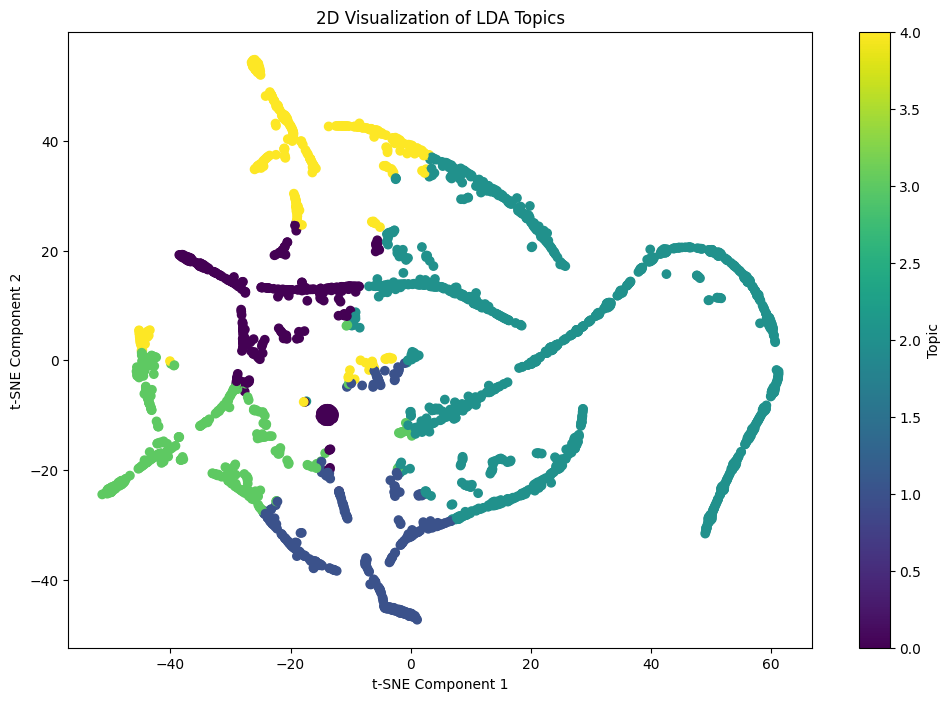

Topic #1: exercise, gene, training, study, change, dna, snp, response, body, analysis
Topic #2: polymorphism, genotype, allele, gene, athlete, study, control, performance, group, endurance
Topic #3: risk, study, association, physical, activity, genetic, associated, obesity, polymorphism, gene
Topic #4: exercise, genotype, muscle, polymorphism, training, ace, response, gene, allele, associated
Topic #5: physical, activity, exercise, gene, polymorphism, bdnf, study, association, disease, cognitive

Cluster counts:
LDA Cluster
0     324
1     305
2    1141
3     332
4     328
Name: count, dtype: int64


In [21]:
# LDA
articles, lda_model, doc_topics, tsne_data = lda_topic_analysis(articles, num_topics=5, num_top_words=10)

print("\nCluster counts:")
print(articles['LDA Cluster'].value_counts().sort_index())

In [58]:
# Example usage
cluster_label = 0  # Specify the cluster label you want to summarize
combined_text = combine_abstracts(articles, cluster_label)

# If the combined text is too long, truncate it for the model (e.g., limit to the first 1000 tokens)
# Adjust as needed to fit your GPU/CPU constraints
combined_text = combined_text[:3000]  # Truncate if needed

# Display keywords only for cluster 0
group = 0
if group in clusters:
    print(f'Cluster {group} keywords: {clusters[group]}')
else:
    print(f"Cluster {group} not found in clusters.")

summary = summarize_text(combined_text)
print("Cluster Summary:")
print(summary)


Cluster 0 keywords: ['pa', 'causal', 'activity', 'physical', 'risk', 'mr', 'study', 'mendelian', 'association', 'randomization']


The model 'BertModel' is not supported for summarization. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGeneration'].


AttributeError: 'SummarizationPipeline' object has no attribute 'prefix'

In [ ]:
save_to_csv(articles, 'NEW_QUERY.csv')

In [22]:
articles.head()

,Authors,Title,Abstract,Summary,PublicationDate,PubMedURL,Journal,LongitudinalStudy,SystematicReview,MetaAnalysis,HumanStudy,AnimalStudy,Preprocessed_Abstract,Cluster,BERT Cluster,LDA Cluster
0,"Leghari Shahzeb, Santos Raziel, Ghumman Abdull...",Genetic and Biotechnological Approaches to Ges...,Background Gestational diabetes mellitus (GDM)...,Conventional diagnostic approaches may not acc...,,https://pubmed.ncbi.nlm.nih.gov/39469345/,Cureus,0,0,0,1,0,background gestational diabetes mellitus (gdm)...,2,5,2
1,"Mei Tao, Li Xiaoxia, Li Yanchun, Yang Xiaolin,...",Genetic markers and predictive model for indiv...,This study aims to utilize Genome-Wide Associa...,"Additionally, we analyze the potential biologi...",,https://pubmed.ncbi.nlm.nih.gov/39416505/,Biology of sport,0,0,0,1,0,study aim utilize genome-wide association anal...,3,6,0
2,"Sakamoto Shota, Kakehi Saori, Abudurezake Abul...",Sex-specific impact of <i>GCKR</i> rs1260326 p...,Metabolic syndrome involves health problems in...,Metabolic syndrome involves health problems in...,,https://pubmed.ncbi.nlm.nih.gov/39346030/,Therapeutic advances in endocrinology and meta...,0,0,0,0,0,metabolic syndrome involves health problem inf...,2,5,2
3,"Xu Rui, Li Yan-Yan, Xu Hong",Mendelian randomization analysis reveals no ca...,Recent research has indicated a potential asso...,Recent research has indicated a potential asso...,,https://pubmed.ncbi.nlm.nih.gov/39345885/,Frontiers in endocrinology,0,0,0,0,0,recent research indicated potential associatio...,2,37,2
4,"Wei Jiaxin, Hou Shuanglong, Hei Peng, Wang Gang",Thyroid dysfunction and sarcopenia: a two-samp...,Observational studies have shown positive asso...,Observational studies have shown positive asso...,,https://pubmed.ncbi.nlm.nih.gov/39301320/,Frontiers in endocrinology,0,0,0,0,0,observational study shown positive association...,2,37,2


## Analysis

### 8. Analysis

In [ ]:
# N-gram analysis function

from nltk.util import ngrams

def ngram_analysis(df, n=2, top_n=15):
    """
    Performs n-gram analysis on the 'Preprocessed_Abstract' column of the DataFrame.
    
    :param df: DataFrame with 'Preprocessed_Abstract' column containing preprocessed text.
    :param n: The 'n' in n-grams (2 for bigrams, 3 for trigrams, etc.).
    :param top_n: Number of top n-grams to display.
    :return: A bar plot of the top n-grams.
    """
    # Concatenate all the 'Preprocessed_Abstract' into a single string for analysis
    docs_string = ' '.join(df['Preprocessed_Abstract'].tolist())
    
    # Tokenize the document
    docs_list = docs_string.split()
    
    # Create n-grams (bigrams, trigrams, etc.)
    n_grams = list(ngrams(docs_list, n))
    
    # Get the most common n-grams
    top_ngrams = pd.Series(Counter(n_grams)).nlargest(top_n)
    
    # Plot the top n-grams
    top_ngrams.plot.barh(xlabel=f'{n}-gram Frequency', ylabel=f'{n}-gram', 
                         title=f'Top {top_n} {n}-grams: Preprocessed_Abstract')
    plt.show()

ngram_analysis(articles)
ngram_analysis(articles,n=3)


### 9. Visualizations

In [ ]:
# top words heatmap

# Number of words in the heatmap
num_of_words = 20

# Use CountVectorizer to get word counts, excluding specific words, and binarize the occurrences
vectorizer = CountVectorizer(max_features=num_of_words, binary=True)
X = vectorizer.fit_transform(articles['Preprocessed_Abstract'])

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Recalculate the co-occurrence matrix
co_occurrence_matrix = (X.T @ X).toarray()

# Create a DataFrame for the co-occurrence matrix
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=words, columns=words)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(co_occurrence_df, annot=False, cmap='coolwarm', fmt='d')
plt.title('Heatmap of Top 20 Lemmatized Word Co-Occurrences in Abstracts (Excluding "sup" and "sub")')
plt.show()

In [ ]:
# segmented bar chart for themes


import matplotlib.pyplot as plt

# Get unique clusters
clusters = articles_data['Cluster'].unique()

# Initialize an empty dictionary to store counts per theme and cluster
themes_by_cluster = {
    'Longitudinal Study': [],
    'Systematic Review': [],
    'Meta Analysis': [],
    'Human Study': [],
    'Animal Study': []
}

# Iterate through each cluster and count occurrences of each theme
for theme in themes_by_cluster.keys():
    themes_by_cluster[theme] = []
    for cluster in clusters:
        cluster_data = articles_data[articles_data['Cluster'] == cluster]
        if theme == 'Longitudinal Study':
            themes_by_cluster[theme].append(cluster_data['LongitudinalStudy'].sum())
        elif theme == 'Systematic Review':
            themes_by_cluster[theme].append(cluster_data['SystematicReview'].sum())
        elif theme == 'Meta Analysis':
            themes_by_cluster[theme].append(cluster_data['MetaAnalysis'].sum())
        elif theme == 'Human Study':
            themes_by_cluster[theme].append(cluster_data['HumanStudy'].sum())
        elif theme == 'Animal Study':
            themes_by_cluster[theme].append(cluster_data['AnimalStudy'].sum())

# Create a segmented (stacked) bar chart
bar_width = 0.8
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each cluster as a stacked segment for each theme
bottoms = [0] * len(themes_by_cluster)
for i, cluster in enumerate(clusters):
    cluster_counts = [themes_by_cluster[theme][i] for theme in themes_by_cluster]
    ax.bar(themes_by_cluster.keys(), cluster_counts, bar_width, label=f'Cluster {cluster}', bottom=bottoms)
    bottoms = [i + j for i, j in zip(bottoms, cluster_counts)]  # Update bottom for stacking

# Set the labels and title
plt.title('Occurrences of Different Themes in Abstracts, Segmented by Cluster')
plt.ylabel('Number of Articles')
plt.xlabel('Theme')
plt.xticks(rotation=45)
plt.legend(title='Clusters')

# Show the plot
plt.show()

In [ ]:
# PCA

from sklearn.decomposition import PCA

def perform_pca_on_text(df, cluster_col='Cluster', n_components=2, max_words=20, title_suffix=""):
    """
    Perform PCA on text data from a DataFrame and generate a 2D visualization of word vectors, with lemmatization.
    
    :param df: DataFrame containing the articles data with columns 'Title', 'Abstract', and a specified cluster column.
    :param cluster_col: The name of the column containing cluster labels.
    :param n_components: Number of PCA components for dimensionality reduction.
    :param max_words: Maximum number of words to consider for vectorization.
    :param title_suffix: A string to append to the title of the plot for differentiation.
    :return: A 2D plot of PCA-reduced word embeddings, normalized by cluster size.
    """

    # Combine the text from the 'Title' and 'Abstract' columns and apply preprocessing
    text_data = df['Preprocessed_Abstract']

    # Use TfidfVectorizer to create word vectors, focusing on the top words
    vectorizer = TfidfVectorizer(max_features=max_words)
    X = vectorizer.fit_transform(text_data)

    # Get the feature names (words)
    words = vectorizer.get_feature_names_out()

    # Count the number of articles in each cluster
    cluster_sizes = df[cluster_col].value_counts()

    # Create a dictionary of cluster sizes
    cluster_size_dict = cluster_sizes.to_dict()

    # Reduce the dimensionality using PCA to n_components
    pca = PCA(n_components=n_components)
    word_vectors_pca = pca.fit_transform(X.T.toarray())

    # Set up colors for clusters (assign each cluster a different color)
    cluster_colors = {
        0: 'red',
        1: 'blue',
        2: 'green',
        3: 'purple',
        4: 'orange'
    }

    # Create a 2D plot
    plt.figure(figsize=(14, 10))

    # Loop through the words and calculate their normalized occurrence per cluster
    for i, word in enumerate(words):
        word_mask = X[:, i].toarray().flatten() > 0
        word_clusters = df.loc[word_mask, cluster_col].value_counts()

        # Normalize the word occurrence by the size of each cluster
        normalized_word_clusters = {cluster: count / cluster_size_dict[cluster] for cluster, count in word_clusters.items()}

        # Find the cluster with the highest normalized count
        most_representative_cluster = max(normalized_word_clusters, key=normalized_word_clusters.get)

        # Plot the word, using color based on the most representative cluster
        plt.scatter(word_vectors_pca[i, 0], word_vectors_pca[i, 1], marker='o', edgecolors='k', 
                    color=cluster_colors[most_representative_cluster], 
                    label=f"Cluster {most_representative_cluster}" if f"Cluster {most_representative_cluster}" not in plt.gca().get_legend_handles_labels()[1] else "")
        
        # Annotate the points with the corresponding words
        plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]), fontsize=12)

    # Add title, labels, and legend
    plt.title(f'2D Word Embedding Visualization {title_suffix}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True)
    plt.legend(title="Clusters")
    plt.show()

# Usage examples with custom title_suffix:
perform_pca_on_text(articles_data, cluster_col='Cluster', title_suffix=' (DF)')

### 9. Review vs non-review analysis

In [29]:
og_query = '("genes" OR "genetics" OR "GWAS" OR "genomic" OR "hereditary") AND ("exercise" OR "physical activity" OR "fitness" OR "training" OR "aerobic")'
max_results = 10000  # Adjust the number of results to retrieve as needed
n_key_words = 10     # Adjust number of key words you want
n_clusters = 5       # Adjust number of clusters you want for the k-means clustering algorithm


In [30]:
# ONLY REVIEW PAPERS

# Perform the search and retrieve the records
records_review = search_pubmed(og_query, max_results, review_papers_only = True)

# Parse the retrieved records to extract the desired information
articles_data_review = pd.DataFrame(extract_article_info(records_review))

# Tokenize and Lemmitize the title and abstract and add it to a new col
articles_data_review = tokenize_and_lemmatize(articles_data_review)

# Perform k-nearest cluster on the data to group the articles into different groups.
articles_data_review, clusters_review = cluster_and_filter_relevance(articles_data_review, n_clusters = n_clusters, n_key_words = n_key_words)

for group in sorted(clusters_review.keys()):
    print(f'cluster {group} keywords: {clusters_review[group]}')

print("\nCluster counts:")
print(articles_data_review['Cluster'].value_counts().sort_index())

Query: ("genes" OR "genetics" OR "GWAS" OR "genomic" OR "hereditary") AND ("exercise" OR "physical activity" OR "fitness" OR "training" OR "aerobic") AND ( 0000/01/01[Date - Publication] : 2024/09/10[Date - Publication]) AND (review[pt])
Total articles found for the query: 11715
cluster 0 keywords: ['cancer', 'cell', 'tumor', 'glycolysis', 'breast', 'metabolism', 'metabolic', 'cells', 'warburg', 'aerobic']
cluster 1 keywords: ['muscle', 'skeletal', 'exercise', 'mitochondrial', 'protein', 'sarcopenia', 'metabolic', 'expression', 'function', 'mass']
cluster 2 keywords: ['disease', 'cell', 'genetic', 'exercise', 'clinical', 'gene', 'review', 'patient', 'study', 'research']
cluster 3 keywords: ['fitness', 'plant', 'host', 'evolution', 'selection', 'resistance', 'evolutionary', 'gene', 'genetic', 'population']
cluster 4 keywords: ['obesity', 'diabetes', 'physical', 'risk', 'activity', 'weight', 'disease', 'factor', 'metabolic', 'insulin']

Cluster counts:
Cluster
0     850
1     504
2    51

In [32]:
#Non-Review papers

# Perform the search and retrieve the records
records = search_pubmed(og_query, max_results)

# Parse the retrieved records to extract the desired information
articles_data = pd.DataFrame(extract_article_info(records))

# Add theme classifications to articles with key words
articles_data = classify_articles(articles_data)

#remove overlapping articles, so this is just non-review papers
overlap = pd.merge(articles_data_review, articles_data, on='Title')
articles_data = articles_data[~articles_data['Title'].isin(overlap['Title'])]

# Tokenize and Lemmitize the title and abstract and add it to a new col
articles_data = tokenize_and_lemmatize(articles_data)

# Perform k-nearest cluster on the data to group the articles into different groups.
articles_data, clusters = cluster_and_filter_relevance(articles_data, n_clusters = n_clusters, n_key_words = n_key_words)

for group in sorted(clusters.keys()):
    print(f'cluster {group} keywords: {clusters[group]}')

print("\nCluster counts:")
print(articles_data['Cluster'].value_counts().sort_index())

Query: ("genes" OR "genetics" OR "GWAS" OR "genomic" OR "hereditary") AND ("exercise" OR "physical activity" OR "fitness" OR "training" OR "aerobic") AND ( 0000/01/01[Date - Publication] : 2024/09/10[Date - Publication])
Total articles found for the query: 115062
cluster 0 keywords: ['disease', 'study', 'patient', 'genetic', 'risk', 'model', 'data', 'variant', 'training', 'clinical']
cluster 1 keywords: ['strain', '16', 'genus', 'dna', 'nov', 'rrna', 'sequence', 'specie', 'phylogenetic', 'iso']
cluster 2 keywords: ['cancer', 'tumor', 'prognostic', 'cell', 'prognosis', 'risk', 'immune', 'patient', 'gene', 'model']
cluster 3 keywords: ['cell', 'exercise', 'muscle', 'expression', 'mouse', 'gene', 'protein', 'mitochondrial', 'effect', 'induced']
cluster 4 keywords: ['gene', 'resistance', 'fitness', 'strain', 'host', 'mutation', 'genetic', 'genome', 'population', 'bacteria']

Cluster counts:
Cluster
0    3253
1     287
2    1116
3    1756
4    2705
Name: count, dtype: int64


In [34]:
review_df = articles_data_review
nonreview_df = articles_data

review_df = review_df.rename(columns={'Cluster': 'review_cluster'})
nonreview_df = nonreview_df.rename(columns={'Cluster': 'nonreview_cluster'})

overlap = pd.merge(review_df, nonreview_df, on='Title')

#overlap should show 0 now
overlap.shape[0]

0

In [43]:
nonreview_df.head()

,Authors,Title,Abstract,Summary,PublicationDate,PubMedURL,Journal,LongitudinalStudy,SystematicReview,MetaAnalysis,HumanStudy,AnimalStudy,Preprocessed_Abstract,Total_Cluster,alternate_cluster
0,"Zhao Wenguo, Wang Jiazheng, Zhao Feihu, Li Yaq...",SUMOylation modification of HNRNPK at the K422...,Glioblastoma multiforme (GBM) is a highly hete...,Although the proneural subtype is considered t...,,https://pubmed.ncbi.nlm.nih.gov/39494331/,International journal of biological sciences,0,0,1,0,0,glioblastoma multiforme (gbm) highly heterogen...,3,2
1,"Rueangmongkolrat Nattanan, Uthaipaisanwong Pic...",The role of microbiomes in cooperative detoxif...,Microbial arsenic (As) transformations play a ...,This study utilized a combination of high-thro...,,https://pubmed.ncbi.nlm.nih.gov/39494289/,PeerJ,0,0,0,0,0,microbial arsenic (as) transformation play vit...,4,2
2,"Yu Min, Li Dan, Zhang Li, Wang Ke",Identification and validation of a prognostic ...,A novel valuable prognostic model has been dev...,A novel valuable prognostic model has been dev...,,https://pubmed.ncbi.nlm.nih.gov/39494284/,PeerJ,0,0,0,1,0,novel valuable prognostic model developed basi...,2,0
3,"Ding Lingling, Zheng Guowan, Zhou Aoni, Song F...",Development and Verification of Diagnosis Mode...,The incidence of papillary thyroid cancer (PTC...,The incidence of papillary thyroid cancer (PTC...,,https://pubmed.ncbi.nlm.nih.gov/39494207/,Journal of inflammation research,0,0,0,1,0,incidence papillary thyroid cancer (ptc) incre...,2,2
5,"Wu Haiyan, Zhou Ruoyu, Kong Hanxin, Yang Jieqi...",Exercise Attenuates Doxorubicin-Induced Myocar...,<b>Objective:</b> Doxorubicin (DOX) is an exte...,"Therefore, this study aimed to explore the mec...",,https://pubmed.ncbi.nlm.nih.gov/39493373/,Journal of immunology research,0,0,0,0,1,<b>objective:</b> doxorubicin (dox) extensivel...,3,2


In [ ]:
def assign_to_cluster_based_on_similarity(df, clusters):
    """
    Assign each article to the cluster it is most similar to based on the Preprocessed_Abstract column using cosine similarity.
    
    :param df: DataFrame with a 'Preprocessed_Abstract' column.
    :param clusters: Dictionary where keys are cluster numbers and values are lists of words associated with each cluster.
    :return: DataFrame with a new 'Assigned_Cluster' column.
    """
    # Convert cluster keywords into a list of cluster strings for vectorization
    cluster_strings = {cluster: ' '.join(words) for cluster, words in clusters.items()}

    # Combine cluster keywords into a single list for vectorization
    cluster_texts = list(cluster_strings.values())

    # Create a TfidfVectorizer to vectorize both the article abstracts and cluster keywords
    vectorizer = TfidfVectorizer(stop_words='english')

    # List to store the assigned clusters for each article
    assigned_clusters = []

    # Loop over each article in the DataFrame
    for _, row in df.iterrows():
        # Vectorize the article Preprocessed_Abstract
        article_text = [row['Preprocessed_Abstract']]

        # Fit and transform the combined article and cluster texts
        tfidf_matrix = vectorizer.fit_transform(article_text + cluster_texts)

        # Compute cosine similarity between the article and all clusters
        similarity_matrix = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1:])

        # Find the cluster with the highest similarity score
        most_similar_cluster = max(enumerate(similarity_matrix[0]), key=lambda x: x[1])[0]

        # Append the most similar cluster to the list
        assigned_clusters.append(most_similar_cluster)

    # Append the 'alternate_cluster' column to the DataFrame
    df['alternate_cluster'] = assigned_clusters

    return df

# Apply the function to assign clusters
nonreview_df = assign_to_cluster_based_on_similarity(nonreview_df, clusters_review)

# Apply the function to assign clusters
review_df = assign_to_cluster_based_on_similarity(review_df, clusters)

# Display the updated DataFrame with the new 'Assigned_Cluster' column
review_df.head()


In [40]:
review_df.head()


,Authors,Title,Abstract,Summary,PublicationDate,PubMedURL,Journal,Preprocessed_Abstract,Review_Cluster,alternate_cluster
0,"Elkhalifa Shuayb, Elbashir Haggar, Abuzakouk M...",When allergies have no name: is idiopathic ana...,Idiopathic anaphylaxis (IA) is a severe allerg...,Idiopathic anaphylaxis (IA) is a severe allerg...,,https://pubmed.ncbi.nlm.nih.gov/39493748/,Frontiers in allergy,idiopathic anaphylaxis (ia) severe allergic re...,2,3
1,"Xu Yingying, Xiao Weihua",NAD+: An Old but Promising Therapeutic Agent f...,More than a century after the discovery of nic...,The aetiology of skeletal muscle ageing is com...,,https://pubmed.ncbi.nlm.nih.gov/39492424/,Ageing research reviews,century discovery nicotinamide adenine dinucle...,1,3
2,"Choudhary Ratan Kumar, Kumar B V Sunil, Sekhar...",Animal Wellness: The Power of Multiomics and I...,The livestock industry faces significant chall...,Omics methods are routinely used to identify g...,,https://pubmed.ncbi.nlm.nih.gov/39484643/,Veterinary medicine international,livestock industry face significant challenges...,3,4
3,"Liu Yaqi, Fu Xiying, Zhao Xing, Cui Ranji, Yan...",The role of exercise-related FNDC5/irisin in d...,The complexity of depression presents a signif...,The complexity of depression presents a signif...,,https://pubmed.ncbi.nlm.nih.gov/39484160/,Frontiers in pharmacology,complexity depression present significant chal...,2,3
4,"Arueyingho Oritsetimeyin V, Al-Taie Anmar, McC...",Scoping review: Machine learning interventions...,Healthcare institutions focus on improving the...,"According to the World Health Organization, th...",,https://pubmed.ncbi.nlm.nih.gov/39444734/,Digital health,healthcare institution focus improving quality...,2,0


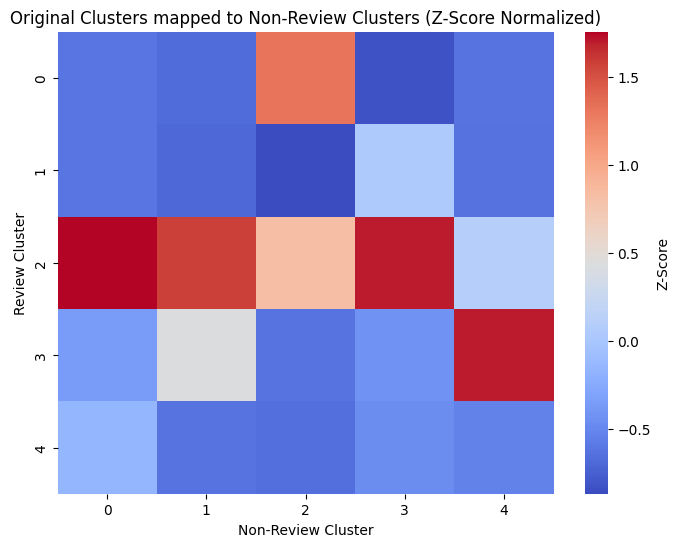

In [41]:
# Non-review heatmap: assigned cluster vs alternate_cluster
# This maps the non-review papers clustered by k-means to the clusters given to review papers
heatmap_data_alternate = pd.crosstab(review_df['Review_Cluster'], review_df['alternate_cluster'])

# Z-score normalization for alternate_cluster
heatmap_data_alternate_normalized = (heatmap_data_alternate - heatmap_data_alternate.mean()) / heatmap_data_alternate.std()

# Plot the heatmap for Cluster vs alternate_cluster (Z-score Normalized)
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_alternate_normalized, annot=False, cmap='coolwarm', cbar_kws={'label': 'Z-Score'}, cbar=True)
plt.title('Original Clusters mapped to Non-Review Clusters (Z-Score Normalized)')
plt.xlabel('Non-Review Cluster')
plt.ylabel('Review Cluster')
plt.show()

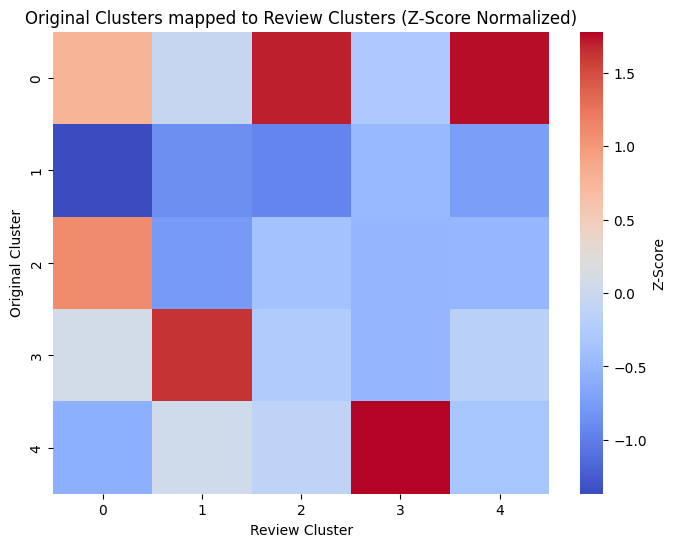

In [44]:
# Review heatmap: assigned cluster vs alternate_cluster
# This maps the review papers clustered by k-means to the clusters given to non-review papers

heatmap_data_alternate = pd.crosstab(nonreview_df['Total_Cluster'], nonreview_df['alternate_cluster'])

# Z-score normalization for alternate_cluster
heatmap_data_alternate_normalized = (heatmap_data_alternate - heatmap_data_alternate.mean()) / heatmap_data_alternate.std()

# Plot the heatmap for Cluster vs alternate_cluster (Z-score Normalized)
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_alternate_normalized, annot=False, cmap='coolwarm', cbar_kws={'label': 'Z-Score'}, cbar=True)
plt.title('Original Clusters mapped to Review Clusters (Z-Score Normalized)')
plt.xlabel('Review Cluster')
plt.ylabel('Original Cluster')
plt.show()



In [ ]:
# Example 'perfect' heatmap
data = np.random.randn(5, 5)

# Manually create the "red boxes" by setting higher values for non-diagonal cells
# For example, shift the red boxes off-diagonal
data[0, 0] = 9
data[1, 3] = 5
data[3, 4] = 7
data[2, 1] = 8
data[4, 2] = 7

# Create a DataFrame for the heatmap data, now labeled simply 1-5 for columns and rows
heatmap_data_alternate = pd.DataFrame(data, columns=[i for i in range(1, 6)], 
                                      index=[i for i in range(1, 6)])

# Z-score normalization
heatmap_data_alternate_normalized = (heatmap_data_alternate - heatmap_data_alternate.mean()) / heatmap_data_alternate.std()

# Plot the heatmap with the prominent red boxes
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data_alternate_normalized, annot=False, cmap='coolwarm', cbar_kws={'label': 'Z-Score'}, cbar=True)
plt.title("'Perfect' Heatmap")
plt.xlabel('Alternate Cluster')
plt.ylabel('Cluster')
plt.show()

In [ ]:
perform_pca_on_text(total_df, cluster_col='Total_Cluster', title_suffix=' (Total DF)')
perform_pca_on_text(review_df, cluster_col='Review_Cluster', title_suffix=' (Review DF)')

### 10. Analyzing the difference between human and animal studies

In [ ]:
# Split the data into human studies and animal studies
human_studies = articles_data[articles_data['HumanStudy'] == 1]
animal_studies = articles_data[articles_data['AnimalStudy'] == 1]

# Define the original keywords
human_study_terms = [" human ", " patient", "participants", ' twin ']
animal_study_terms = [" rat ", " mouse ", " mice ", " animal ", " rodent ", "zebrafish", "drosophila", "rabbit", " dog ", " cat ", " monkey ", "non-human primate"]

# Count the number of studies that are both HumanStudy and AnimalStudy
both_studies_count = articles_data[(articles_data['HumanStudy'] == 1) & (articles_data['AnimalStudy'] == 1)].shape[0]

# Total number of human studies
total_human_studies = articles_data[articles_data['HumanStudy'] == 1].shape[0]

# Total number of animal studies
total_animal_studies = articles_data[articles_data['AnimalStudy'] == 1].shape[0]

# Print the counts
print(f"Number of studies that are both HumanStudy AND AnimalStudy: {both_studies_count}")
print(f"Total number of human studies: {total_human_studies}")
print(f"Total number of animal studies: {total_animal_studies}")

In [ ]:
from matplotlib_venn import venn2

# Lowercase and combine the text from the 'Title' and 'Abstract' columns
articles_data['combined_text'] = (articles_data['Title'].fillna('') + ' ' + articles_data['Abstract'].fillna('')).str.lower()

# Count the occurrences of human and animal keywords in each study
articles_data['has_human_keywords'] = articles_data['combined_text'].apply(lambda x: any(term in x for term in human_study_terms))
articles_data['has_animal_keywords'] = articles_data['combined_text'].apply(lambda x: any(term in x for term in animal_study_terms))

# Count studies with only human, only animal, and both sets of keywords
only_human = articles_data[(articles_data['has_human_keywords']) & (~articles_data['has_animal_keywords'])].shape[0]
only_animal = articles_data[(articles_data['has_animal_keywords']) & (~articles_data['has_human_keywords'])].shape[0]
both_human_animal = articles_data[(articles_data['has_human_keywords']) & (articles_data['has_animal_keywords'])].shape[0]

# Total counts for context
total_human = articles_data['has_human_keywords'].sum()
total_animal = articles_data['has_animal_keywords'].sum()

# Display the counts
print(f"Studies with only human keywords: {only_human}")
print(f"Studies with only animal keywords: {only_animal}")
print(f"Studies with both human and animal keywords: {both_human_animal}")

# Step 2: Visualize the Overlap with a Venn Diagram
plt.figure(figsize=(8, 6))
venn2(subsets=(only_human, only_animal, both_human_animal), set_labels=('Human Studies', 'Animal Studies'))
plt.title('Overlap of Human and Animal Studies Based on Keyword Search')
plt.show()


In [ ]:
# data for word counts in human and animal studies


# Initialize counters for the keywords
human_keyword_counter_overlap = Counter()
animal_keyword_counter_overlap = Counter()

# Initialize counters for the keywords in the entire dataset
human_keyword_counter_total = Counter()
animal_keyword_counter_total = Counter()


# Filter the data to get studies marked as both HumanStudy and AnimalStudy
both_studies = articles_data[(articles_data['HumanStudy'] == 1) & (articles_data['AnimalStudy'] == 1)]

# Combine the text from overlapping studies
both_text = both_studies['combined_text']

# Count occurrences in overlapping studies
for text in both_text:
    for term in human_study_terms:
        if term in text:
            human_keyword_counter_overlap[term] += 1
    for term in animal_study_terms:
        if term in text:
            animal_keyword_counter_overlap[term] += 1

# Count occurrences in the entire dataset
for text in articles_data['combined_text']:
    for term in human_study_terms:
        if term in text:
            human_keyword_counter_total[term] += 1
    for term in animal_study_terms:
        if term in text:
            animal_keyword_counter_total[term] += 1

# Convert the counters to DataFrames for easier viewing
human_keywords_df = pd.DataFrame({
    'Overlap Count': pd.Series(human_keyword_counter_overlap),
    'Total Count': pd.Series(human_keyword_counter_total)
}).fillna(0).astype(int)

animal_keywords_df = pd.DataFrame({
    'Overlap Count': pd.Series(animal_keyword_counter_overlap),
    'Total Count': pd.Series(animal_keyword_counter_total)
}).fillna(0).astype(int)

# Calculate the percentage of overlap
human_keywords_df['Overlap Percent'] = (human_keywords_df['Overlap Count'] / human_keywords_df['Total Count'] * 100).round(2)
animal_keywords_df['Overlap Percent'] = (animal_keywords_df['Overlap Count'] / animal_keywords_df['Total Count'] * 100).round(2)

# Sort by Overlap Count for better visibility
human_keywords_df = human_keywords_df.sort_values(by='Overlap Count', ascending=False)
animal_keywords_df = animal_keywords_df.sort_values(by='Overlap Count', ascending=False)

# Display the results
print("Human keywords with overlap, total counts, and overlap percentage:")
print(human_keywords_df)

print("\nAnimal keywords with overlap, total counts, and overlap percentage:")
print(animal_keywords_df)


In [ ]:
# Initialize a matrix to count co-occurrences
co_occurrence_matrix = np.zeros((len(human_study_terms), len(animal_study_terms)))

# Count the co-occurrences of human and animal keywords
for text in both_text:
    for i, human_term in enumerate(human_study_terms):
        if human_term in text:
            for j, animal_term in enumerate(animal_study_terms):
                if animal_term in text:
                    co_occurrence_matrix[i, j] += 1

# Create a DataFrame for the heatmap
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=human_study_terms, columns=animal_study_terms)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(co_occurrence_df, annot=True, cmap='coolwarm', fmt='g')
plt.title('Heatmap of Human vs Animal Keyword Co-occurrences')
plt.xlabel('Animal Keywords')
plt.ylabel('Human Keywords')
plt.show()

In [ ]:

# Combine the text from the 'Title', 'Abstract', and 'Summary' columns
human_text = human_studies['Title'].fillna('') + ' ' + human_studies['Abstract'].fillna('') 
animal_text = animal_studies['Title'].fillna('') + ' ' + animal_studies['Abstract'].fillna('') 

# Use CountVectorizer to find word frequencies
vectorizer = CountVectorizer(stop_words='english')

# Fit the vectorizer on the combined text data
vectorizer.fit(human_text.tolist() + animal_text.tolist())

# Transform the human and animal text data
human_word_counts = vectorizer.transform(human_text)
animal_word_counts = vectorizer.transform(animal_text)

# Convert to DataFrame for easier analysis
human_word_freq = pd.DataFrame(human_word_counts.toarray(), columns=vectorizer.get_feature_names_out())
animal_word_freq = pd.DataFrame(animal_word_counts.toarray(), columns=vectorizer.get_feature_names_out())

# Sum the frequencies for each word
human_word_sum = human_word_freq.sum().sort_values(ascending=False).head(20)
animal_word_sum = animal_word_freq.sum().sort_values(ascending=False).head(20)

# Plot the top words for both human and animal studies
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

human_word_sum.plot(kind='bar', ax=ax[0], color='blue')
ax[0].set_title('Top Words in Human Studies')
ax[0].set_ylabel('Frequency')

animal_word_sum.plot(kind='bar', ax=ax[1], color='green')
ax[1].set_title('Top Words in Animal Studies')

plt.show()

In [ ]:
# Get the top 20 words overall
top_words = (human_word_sum + animal_word_sum).sort_values(ascending=False).head(20)

# Align the human and animal word frequencies with the top words, filling missing words with 0
human_top_words = human_word_sum.reindex(top_words.index, fill_value=0)
animal_top_words = animal_word_sum.reindex(top_words.index, fill_value=0)

# Set the positions and width for the bars
x = np.arange(len(top_words))
width = 0.35

# Create the side-by-side bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, human_top_words, width, label='Human Studies', color='blue')
bars2 = ax.bar(x + width/2, animal_top_words, width, label='Animal Studies', color='green')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Words')
ax.set_ylabel('Frequency')
ax.set_title('Top 20 Words in Human and Animal Studies')
ax.set_xticks(x)
ax.set_xticklabels(top_words.index, rotation=45, ha='right')
ax.legend()

plt.show()